In [12]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

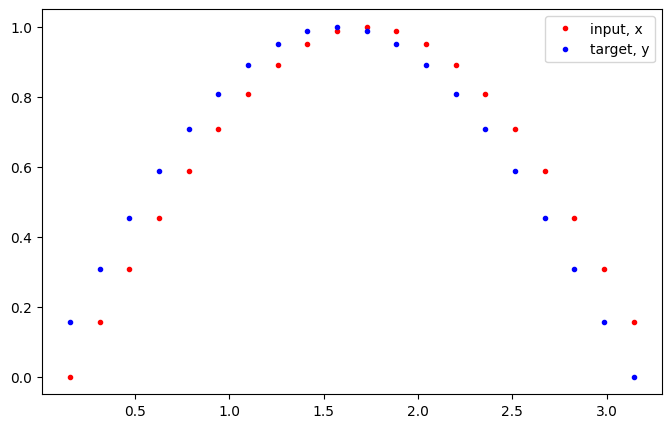

In [ ]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden

In [ ]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [ ]:
input_size=1
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [ ]:
# train the RNN
def train(rnn, n_steps, print_every):

    # initialize the hidden state
    hidden = None

    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]

        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()

    return rnn

Loss:  0.6730172038078308


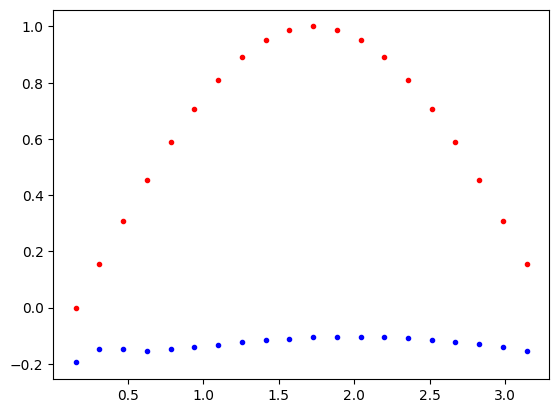

Loss:  0.07578974962234497


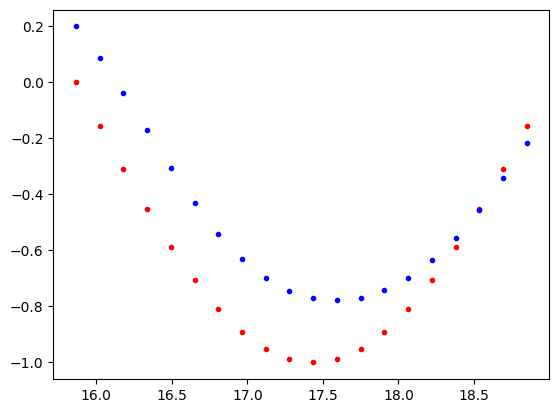

Loss:  0.047234293073415756


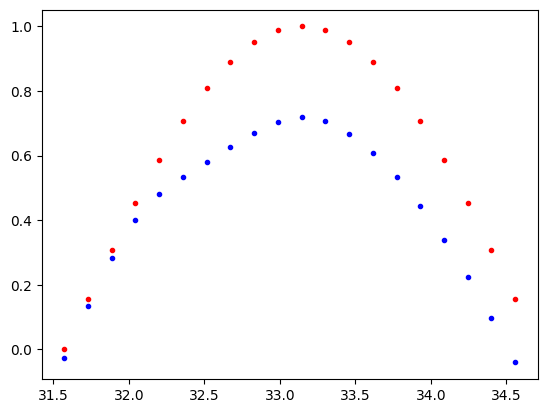

Loss:  0.0014165318571031094


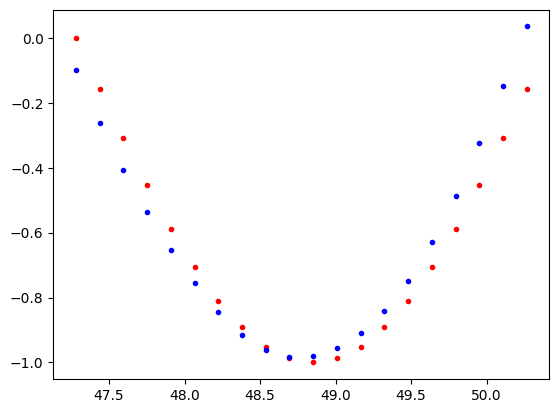

Loss:  0.014856027439236641


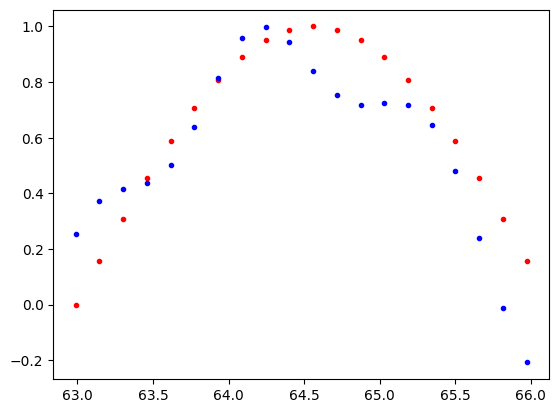

Loss:  0.009224466979503632


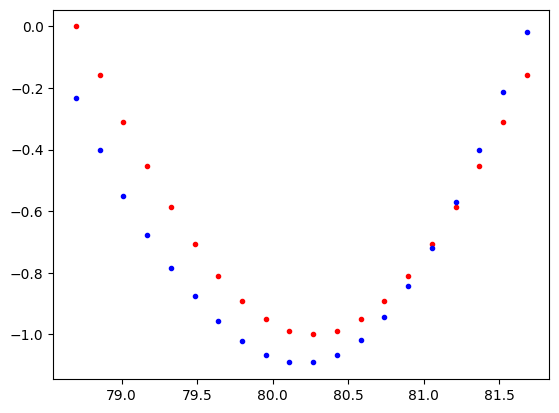

Loss:  0.0025632332544773817


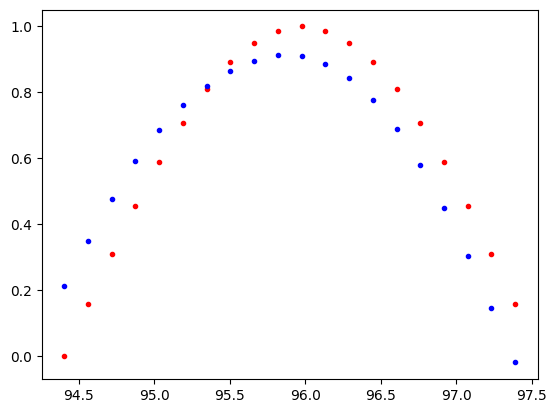

Loss:  0.0039179506711661816


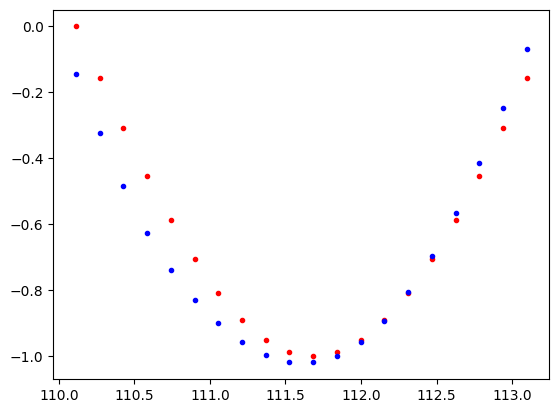

Loss:  0.002382981590926647


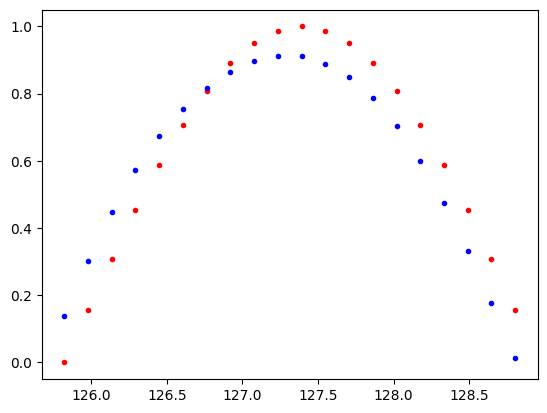

Loss:  0.0009269759175367653


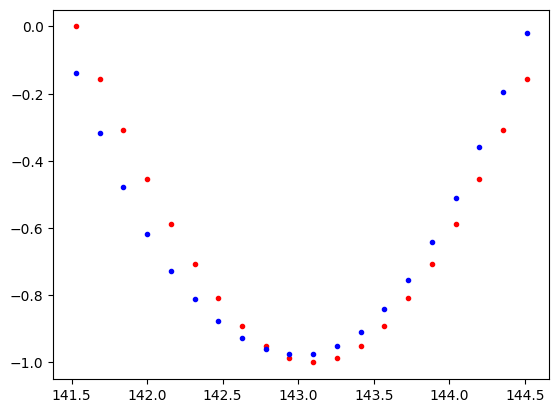

Loss:  0.0013819847954437137


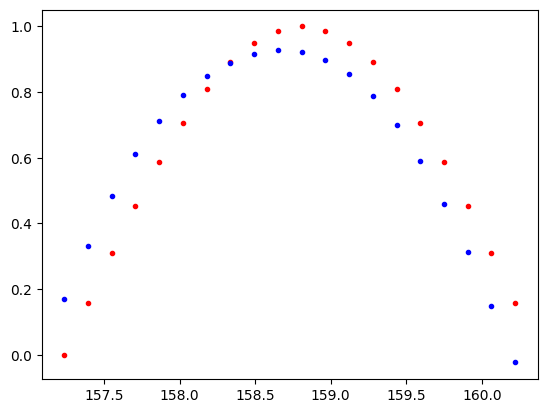

Loss:  0.0010856002336367965


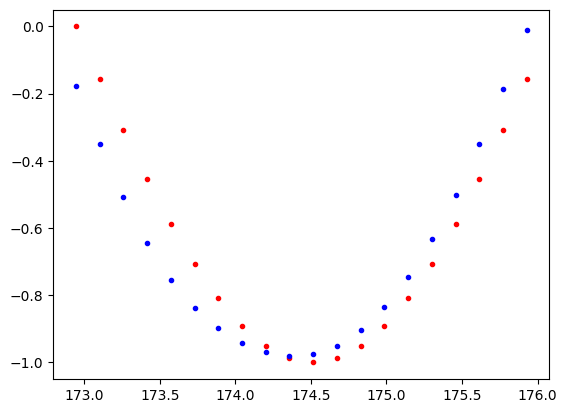

Loss:  0.0006944312481209636


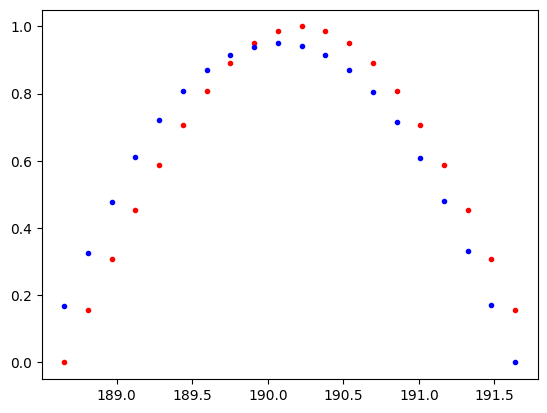

Loss:  0.0007738621206954122


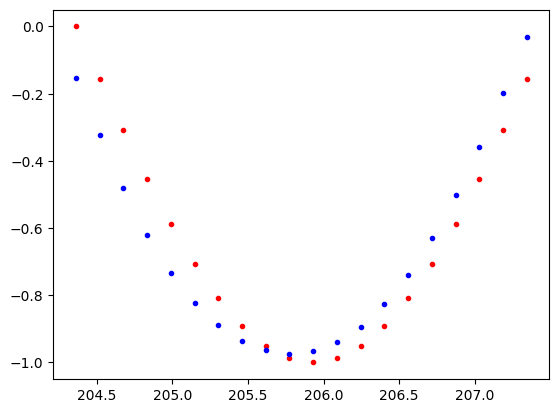

Loss:  0.00045962948934175074


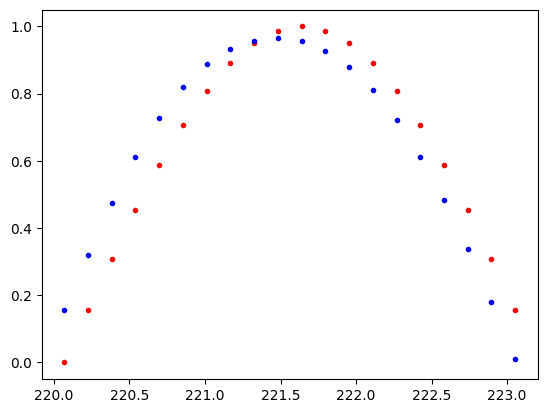

In [ ]:
# train the rnn and monitor results
n_steps = 75
print_every = 5

trained_rnn = train(rnn, n_steps, print_every)

In [ ]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

# Генерация набора данных

In [ ]:
# Generate synthetic sine wave data

# Function to create sequences
def generate_data(seq_length, data_length):
    xs = []
    ys = []
    time_steps = np.linspace(0, data_length, 1000)
    data = np.sin(time_steps)
    for i in range(len(data)-seq_length):

        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys) , time_steps, data



In [ ]:
data_length = 50
seq_length = 20

X, y, time_steps, data = generate_data(seq_length, data_length)


trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [ ]:
print('количество последовательностей из', seq_length, 'точек')
trainX.size()

количество последовательностей из 20 точек


torch.Size([980, 20, 1])

In [ ]:
print('количество точек, продолжающих последовательность')
trainY.size()

количество точек, продолжающих последовательность


torch.Size([980, 1])

#RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        #r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out[:, -1, :])  # Selecting the last output
        # get final output
        #output = self.fc(r_out)

        return output, hidden

##Обучение

In [ ]:
# train the RNN
def train_rnn(rnn, n_steps, print_every, x_tensor, y_tensor, time_steps, data, seq_length):

    # initialize the hidden state
    hidden = None

    for batch_i, step in enumerate(range(n_steps)):

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:
            print(f'Epoch [{batch_i}/{num_epochs}], Loss: {loss.item():.4f}')
            plt.plot(time_steps, data, 'r-', label='Orig') # input
            plt.plot(time_steps[seq_length:], prediction.data.numpy().flatten(), 'b--', label='Pred') # predictions
            plt.legend()
            plt.show()

    return rnn

In [ ]:
input_size=1
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Epoch [0/75], Loss: 0.5096


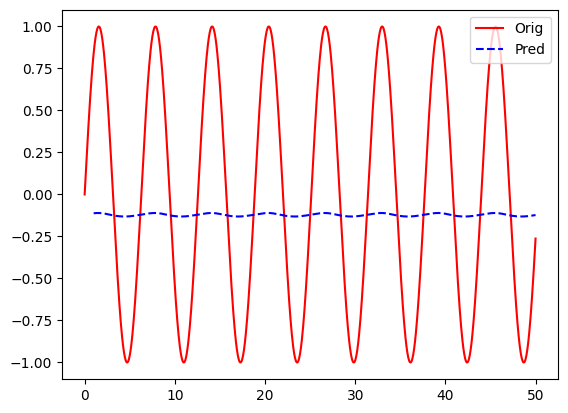

Epoch [5/75], Loss: 0.1534


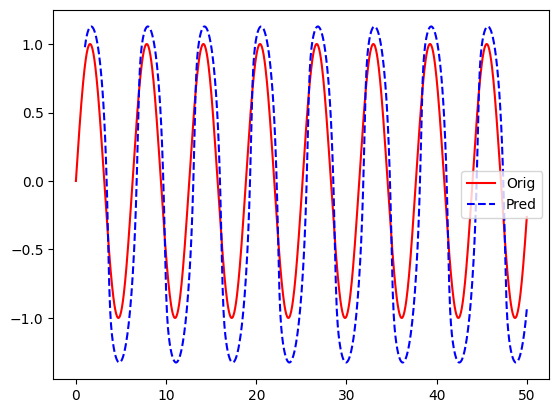

Epoch [10/75], Loss: 0.0417


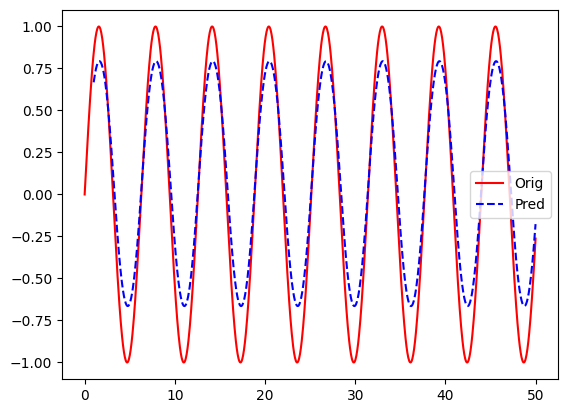

Epoch [15/75], Loss: 0.0199


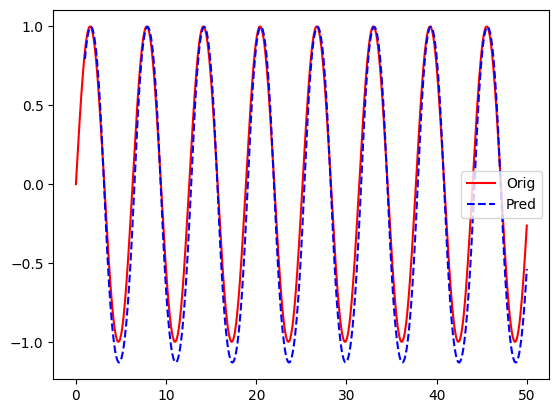

Epoch [20/75], Loss: 0.0117


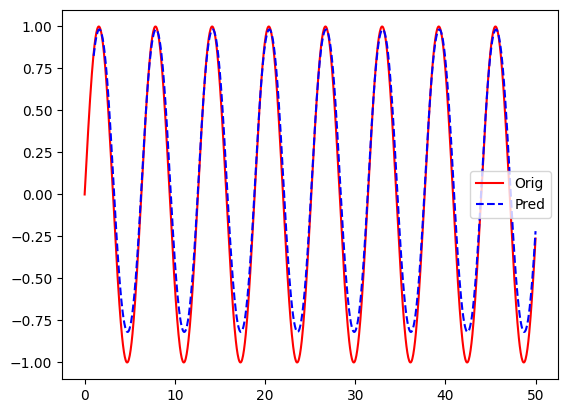

Epoch [25/75], Loss: 0.0049


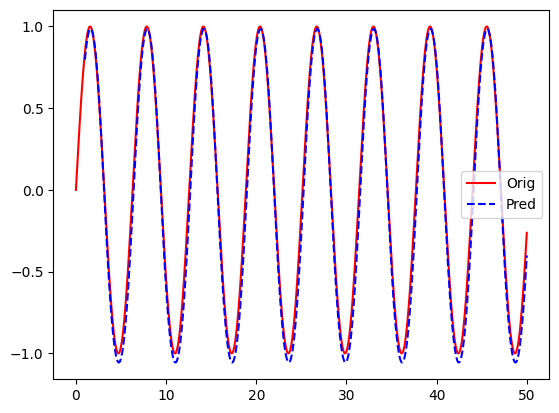

Epoch [30/75], Loss: 0.0015


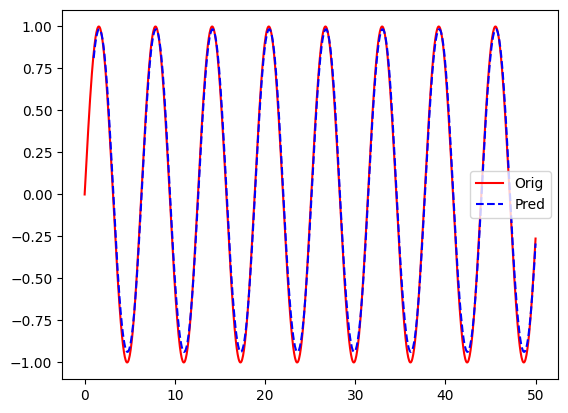

Epoch [35/75], Loss: 0.0010


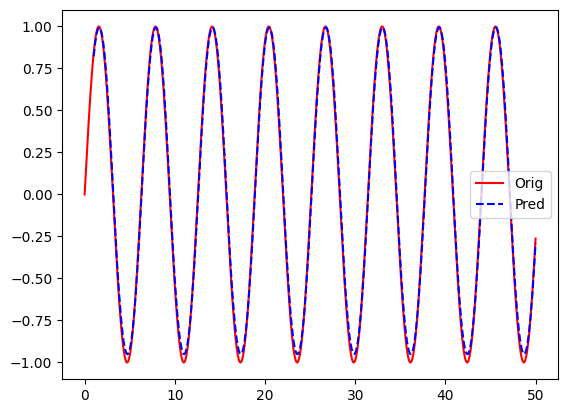

Epoch [40/75], Loss: 0.0013


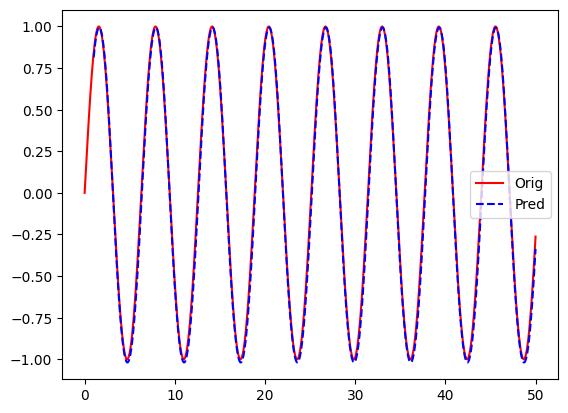

Epoch [45/75], Loss: 0.0010


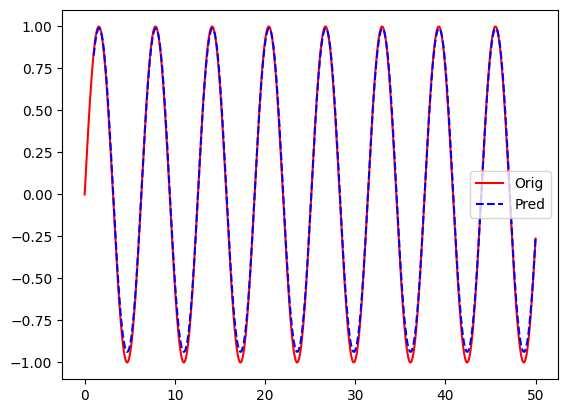

Epoch [50/75], Loss: 0.0004


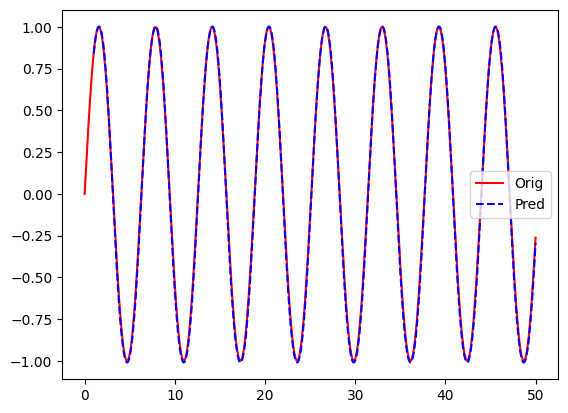

Epoch [55/75], Loss: 0.0003


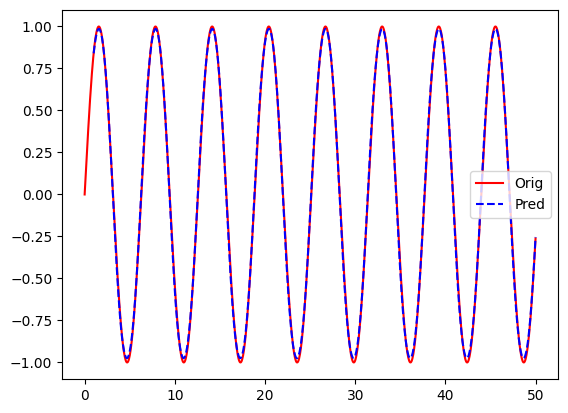

Epoch [60/75], Loss: 0.0001


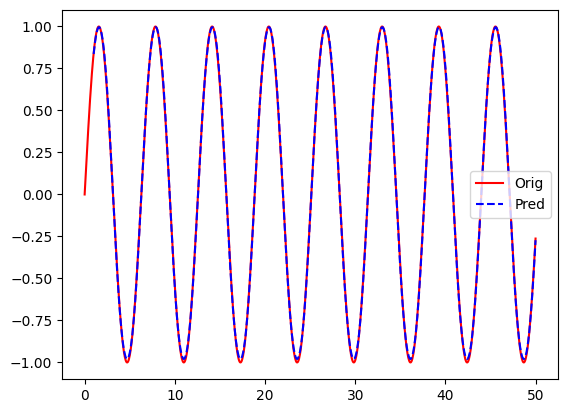

Epoch [65/75], Loss: 0.0002


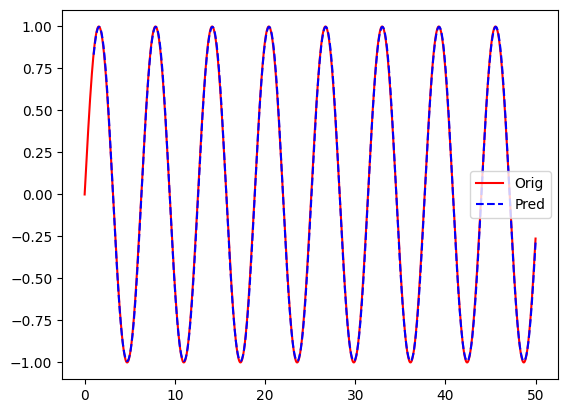

Epoch [70/75], Loss: 0.0001


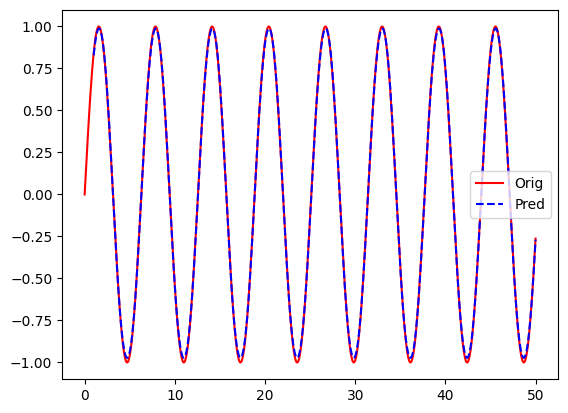

In [ ]:
# train the rnn and monitor results
num_epochs = 75
print_every = 5

trained_lstm = train_rnn(rnn, num_epochs, print_every, trainX, trainY, time_steps, data, seq_length)

#LSTM

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()

        self.hidden_dim=hidden_dim
        self.n_layers = n_layers

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, h0, c0):

        # If hidden and cell states are not provided, initialize them as zeros
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)


        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get LSTM outputs
        r_out, (hn, cn) = self.lstm(x, (h0, c0))
        #r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        #output = self.fc(r_out)

        output = self.fc(r_out[:, -1, :])  # Selecting the last output

        return output, hn, cn

In [ ]:
input_size=1
output_size=1
hidden_dim=100
n_layers=1

# instantiate an LSTM
lstm = LSTM(input_size, output_size, hidden_dim, n_layers)

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)

print(lstm)

LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


##Обучение

In [25]:
# train the LSTM
def train_lstm(lstm, num_epochs, print_every, x_tensor, y_tensor, time_steps, data, seq_length):

    h0, c0 = None, None  # Initialize hidden and cell states
    for batch_i, i in enumerate(range(num_epochs)):

        lstm.train()
        # zero gradients
        optimizer.zero_grad()

        prediction, h0, c0 = lstm(x_tensor, h0, c0)

        # calculate the loss
        loss = criterion(prediction, y_tensor)

        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # Detach hidden and cell states to prevent
        # backpropagation through the entire sequence
        h0 = h0.detach()
        c0 = c0.detach()

        # display loss and predictions
        if batch_i%print_every == 0:
            print(f'Epoch [{batch_i}/{num_epochs}], Loss: {loss.item():.4f}')
            plt.plot(time_steps, data, 'r-', label='Orig') # input
            plt.plot(time_steps[seq_length:], prediction.data.numpy().flatten(), 'b--', alpha=0.7, label='Pred') # predictions
            plt.legend()
            plt.show()

    return lstm


Epoch [0/75], Loss: 0.4985


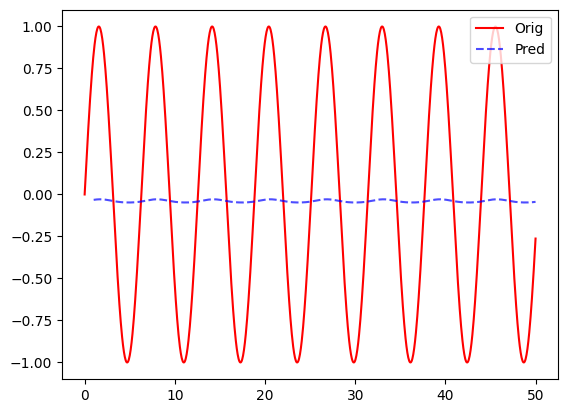

Epoch [5/75], Loss: 0.2407


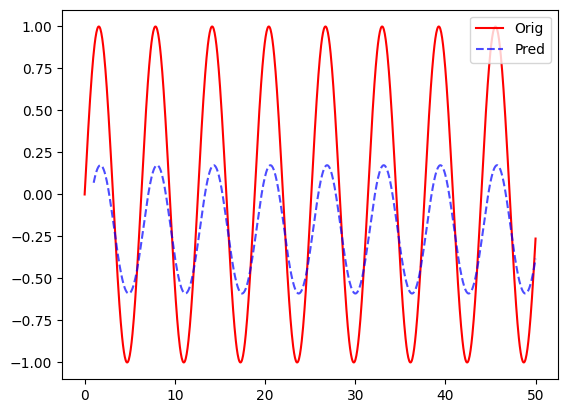

Epoch [10/75], Loss: 0.3617


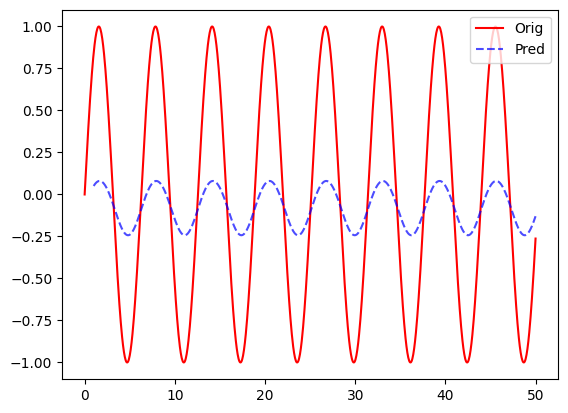

Epoch [15/75], Loss: 0.2861


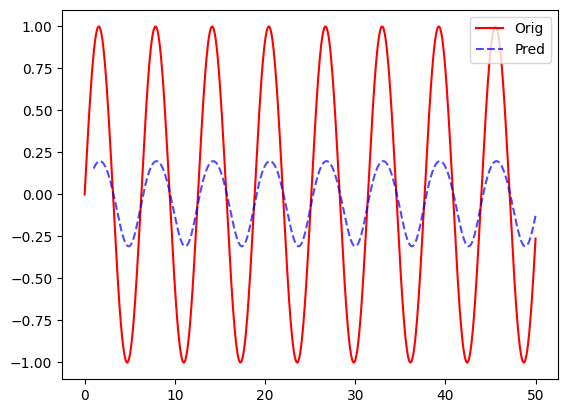

Epoch [20/75], Loss: 0.1099


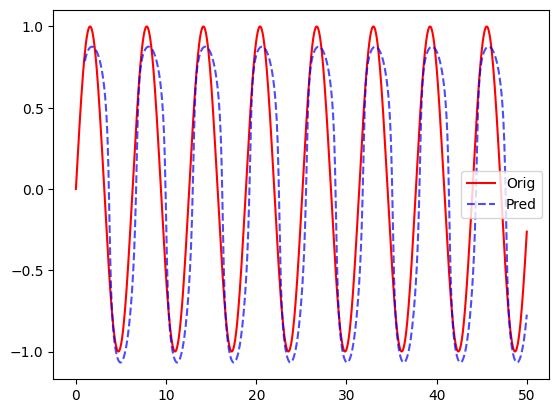

Epoch [25/75], Loss: 0.0602


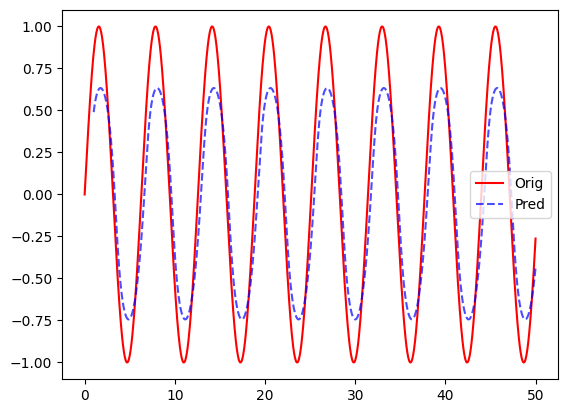

Epoch [30/75], Loss: 0.0461


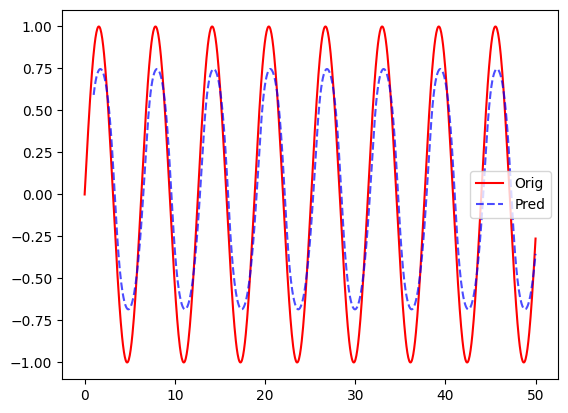

Epoch [35/75], Loss: 0.0306


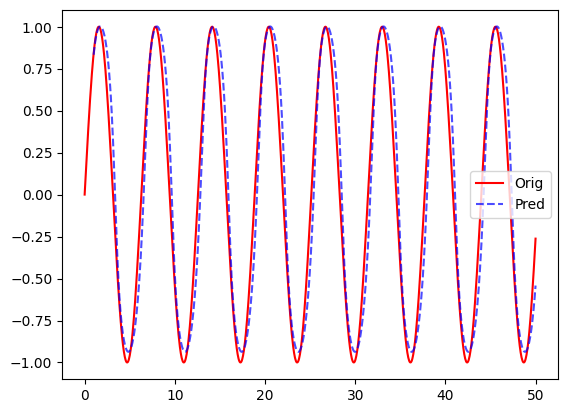

Epoch [40/75], Loss: 0.0166


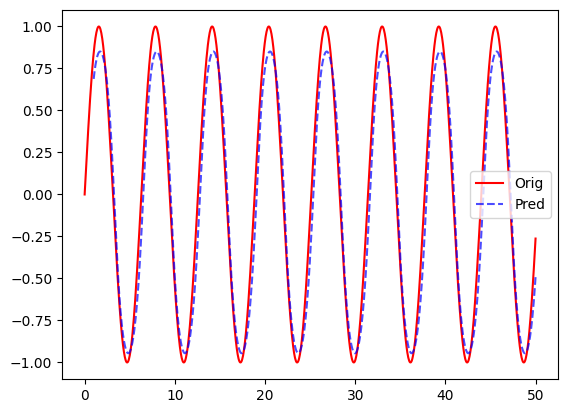

Epoch [45/75], Loss: 0.0143


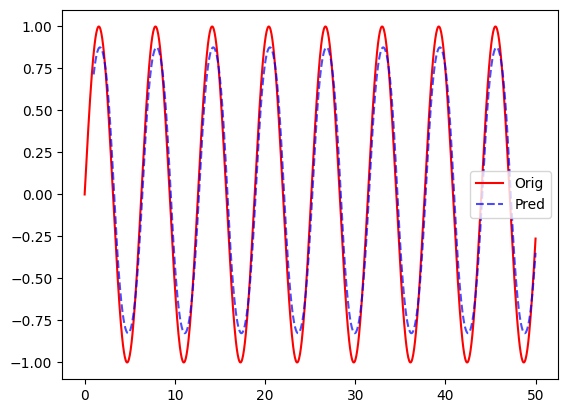

Epoch [50/75], Loss: 0.0078


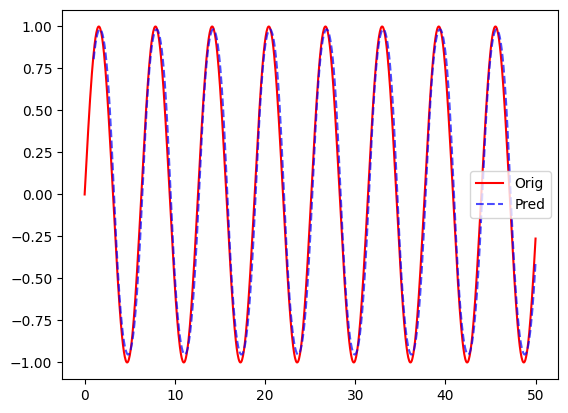

Epoch [55/75], Loss: 0.0055


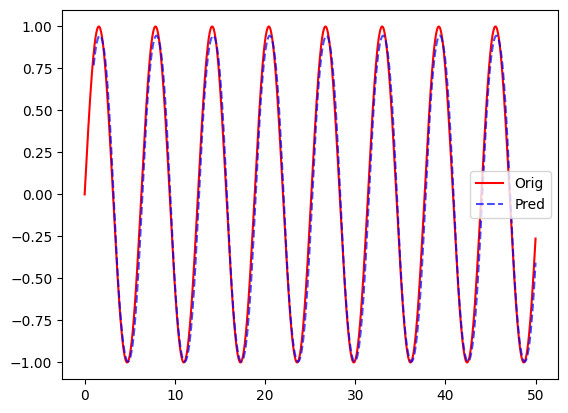

Epoch [60/75], Loss: 0.0044


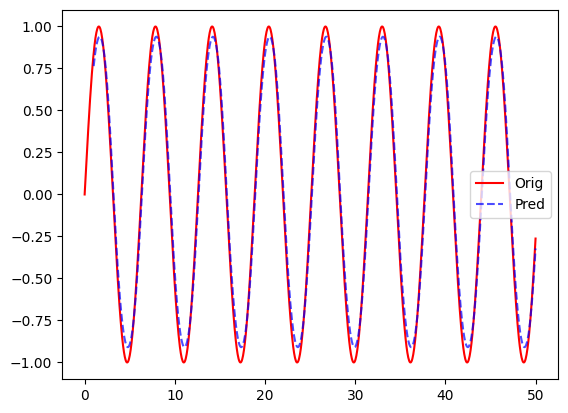

Epoch [65/75], Loss: 0.0025


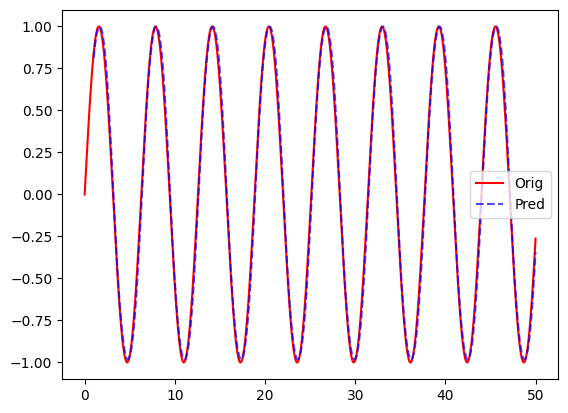

Epoch [70/75], Loss: 0.0015


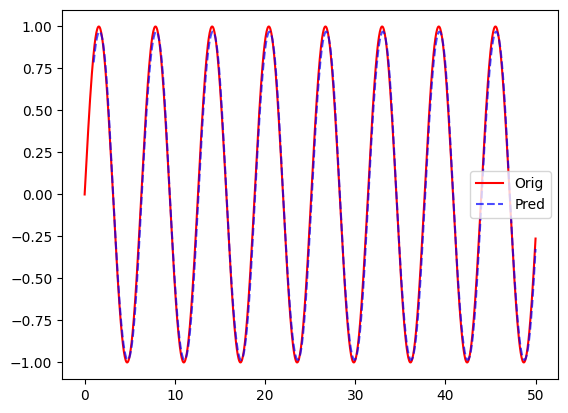

In [ ]:
# train the rnn and monitor results
data_length = 50
seq_length = 20
num_epochs = 75
X, y, time_steps, data = generate_data(seq_length, data_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)


print_every = 5

trained_lstm = train_lstm(lstm, num_epochs, print_every, trainX, trainY, time_steps, data, seq_length)